In [83]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix

## read data 
CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")

In [84]:
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 -  test_data['Susceptible']
cipro_R_prev_2011 = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2011)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_neural_network = metrics.roc_auc_score(y_test, y_predict_test)
print(ROC_AUC_neural_network)

0.14488785370753954
0.1328696925329429
0.6856268467707892


In [60]:
get_effective_threshold = []
incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold.append(sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)) #q_p
  incorrectly_get_X_threshold.append((1 - cipro_R_prev_2011) * (1 - specificity_test)) #c_p

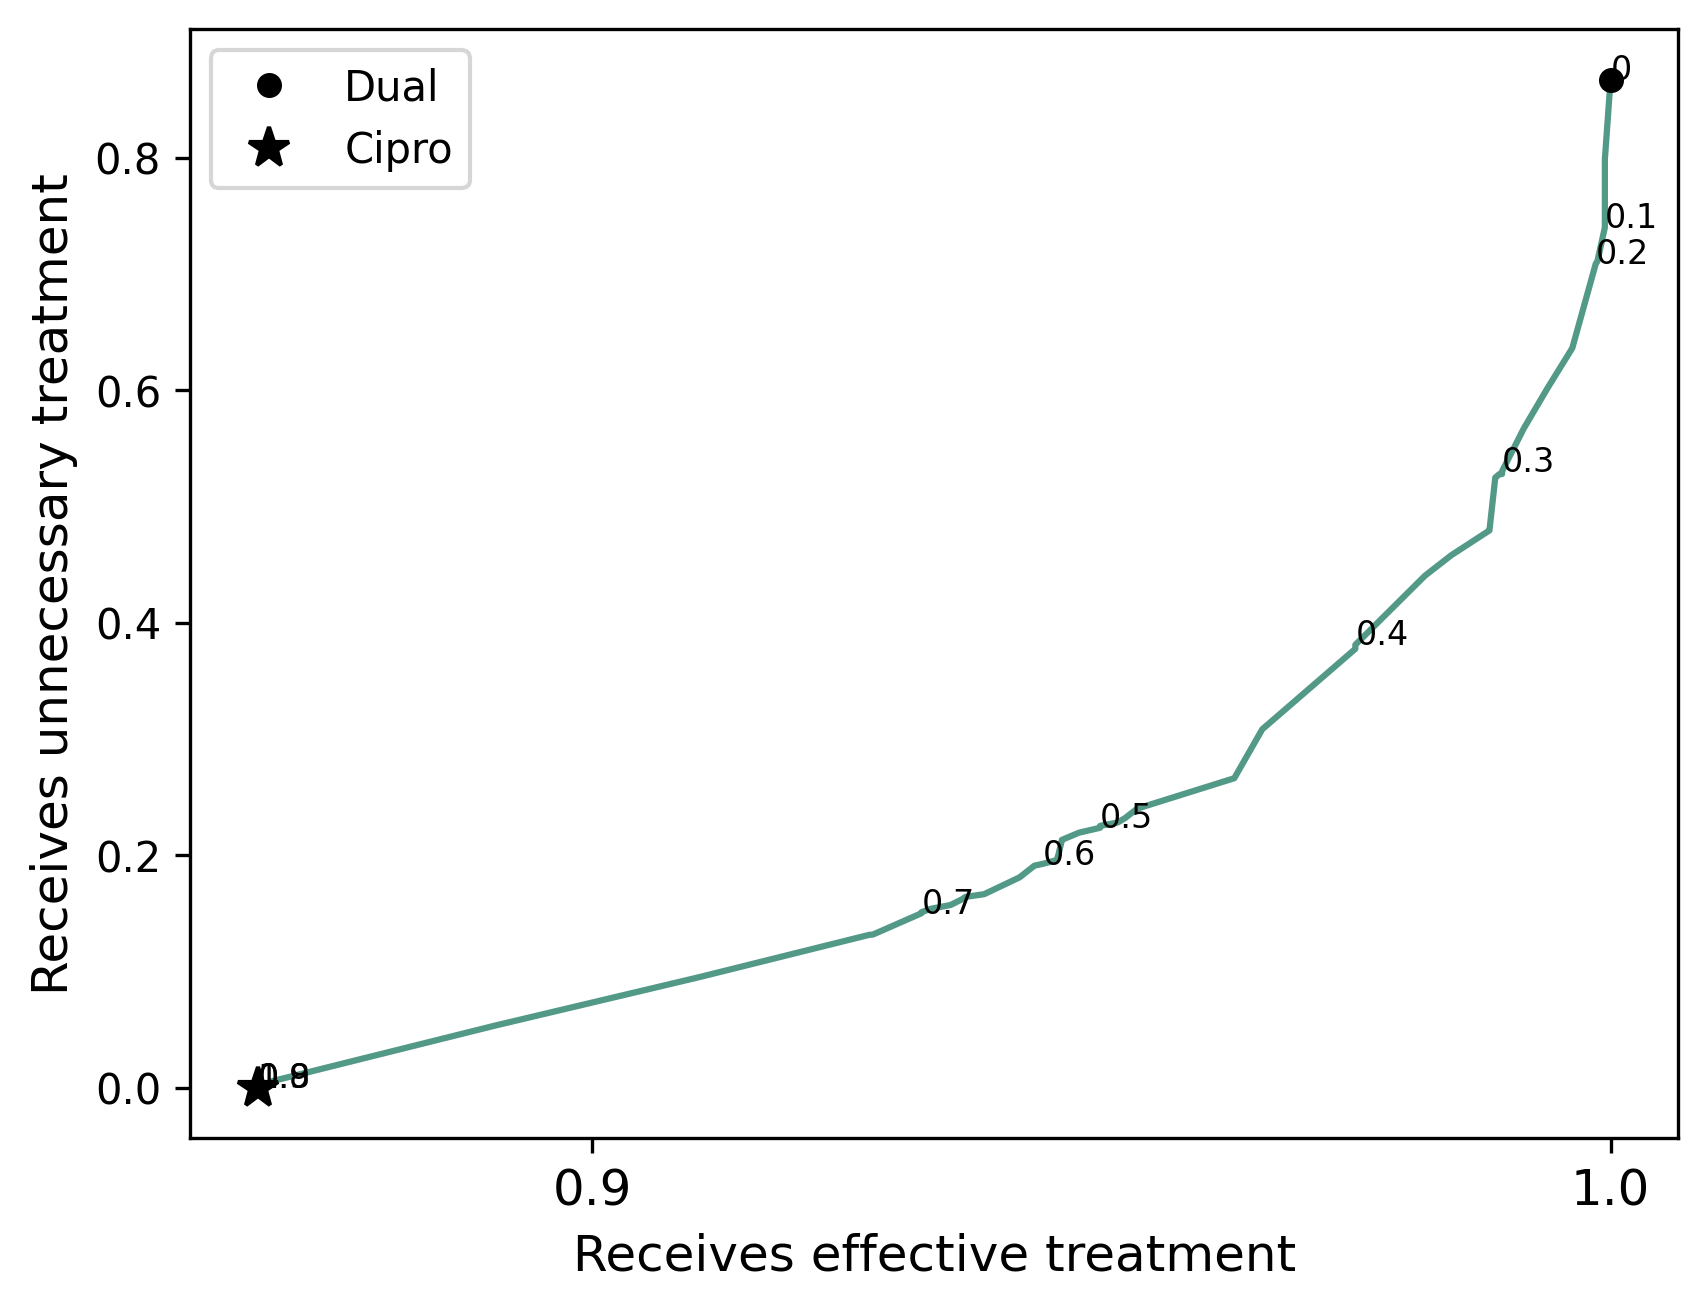

In [61]:


#this is only effective in that they are not getting CIPRO - could get another drug they actually cannot have 
## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
## that 
plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks(np.linspace(0,1,11), fontsize=12)
plt.rcParams['figure.dpi'] = 300

plt.plot(1, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), 0, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index], text_for_graph[x], size = 8)
    x = x+1

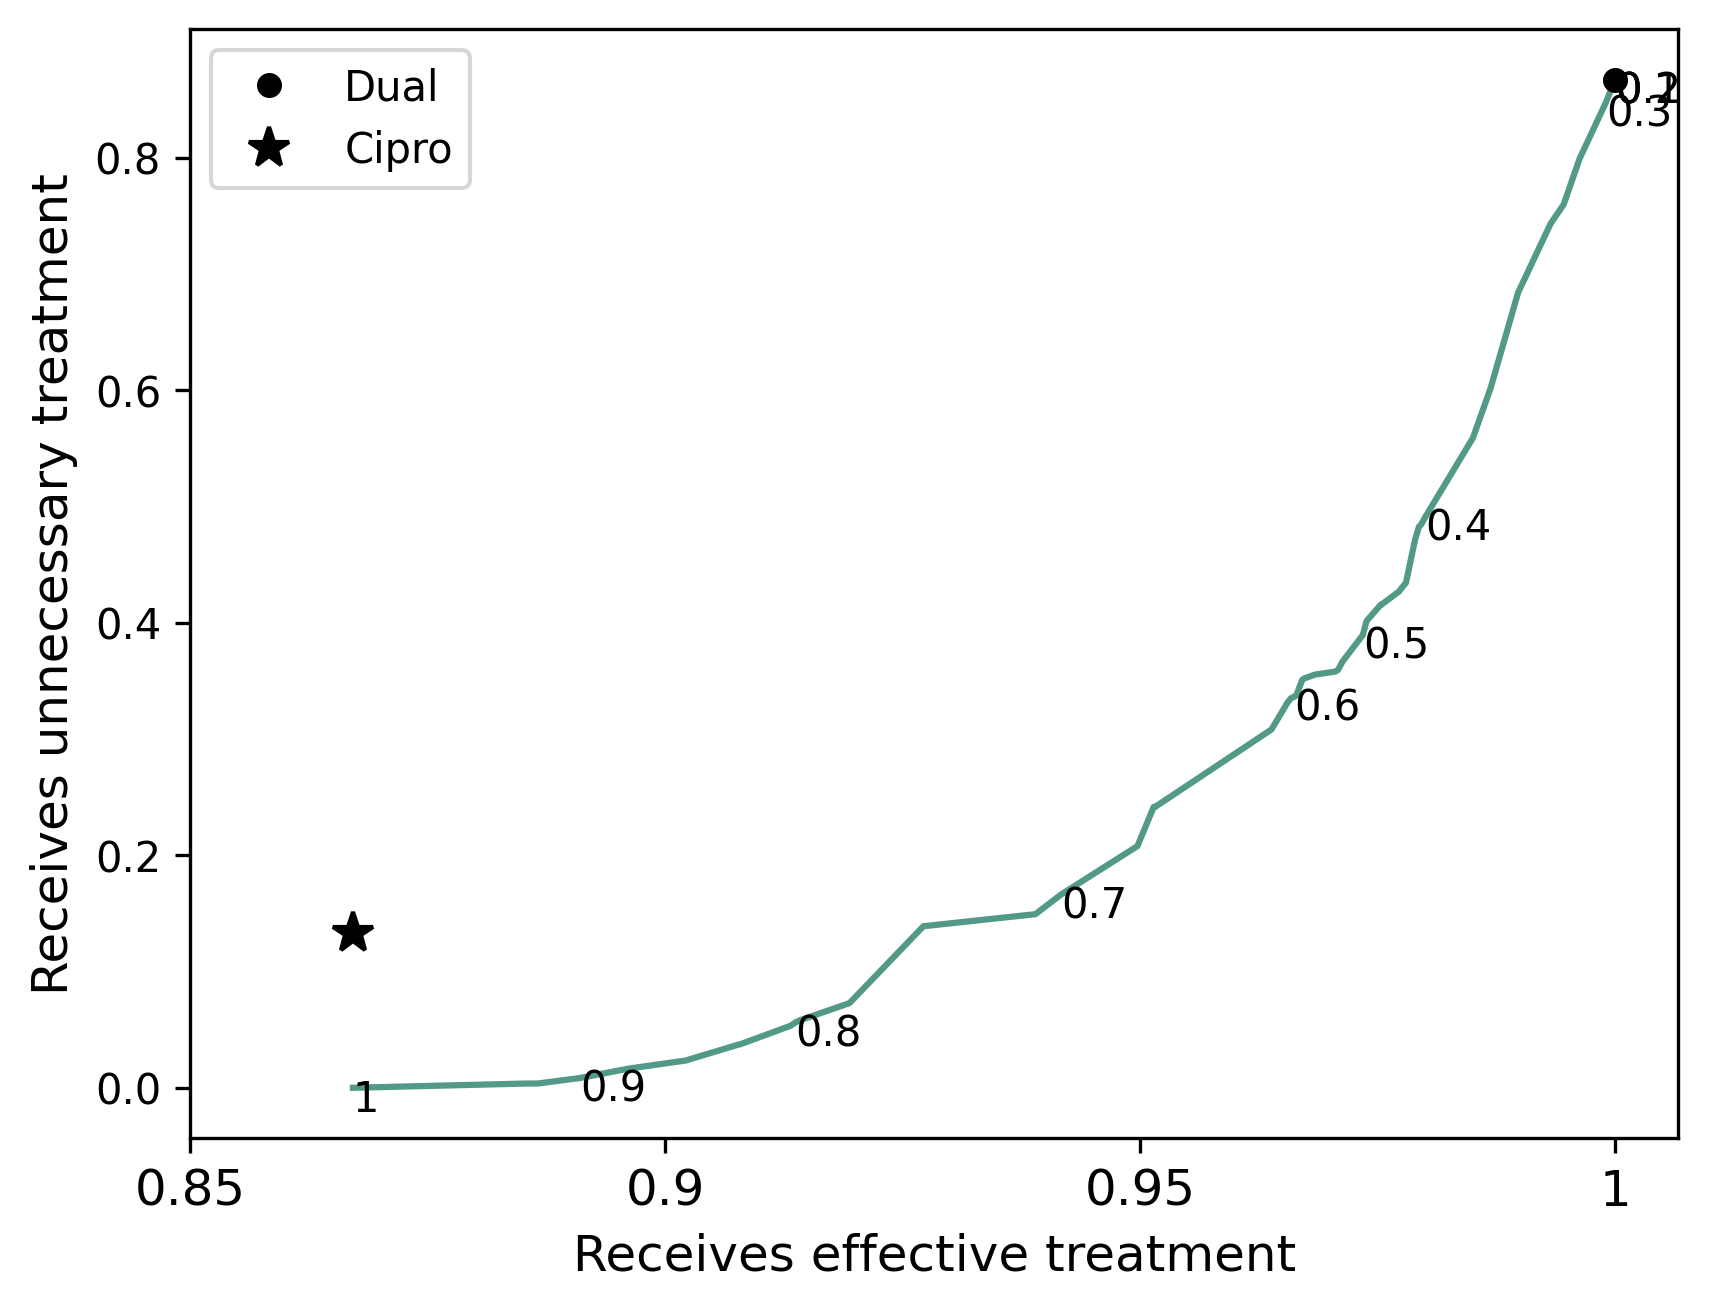

In [40]:

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
plt.plot(1, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")

plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#pt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index]- 0.02, text_for_graph[x])
    x = x+1



0.14488785370753954
0.1328696925329429


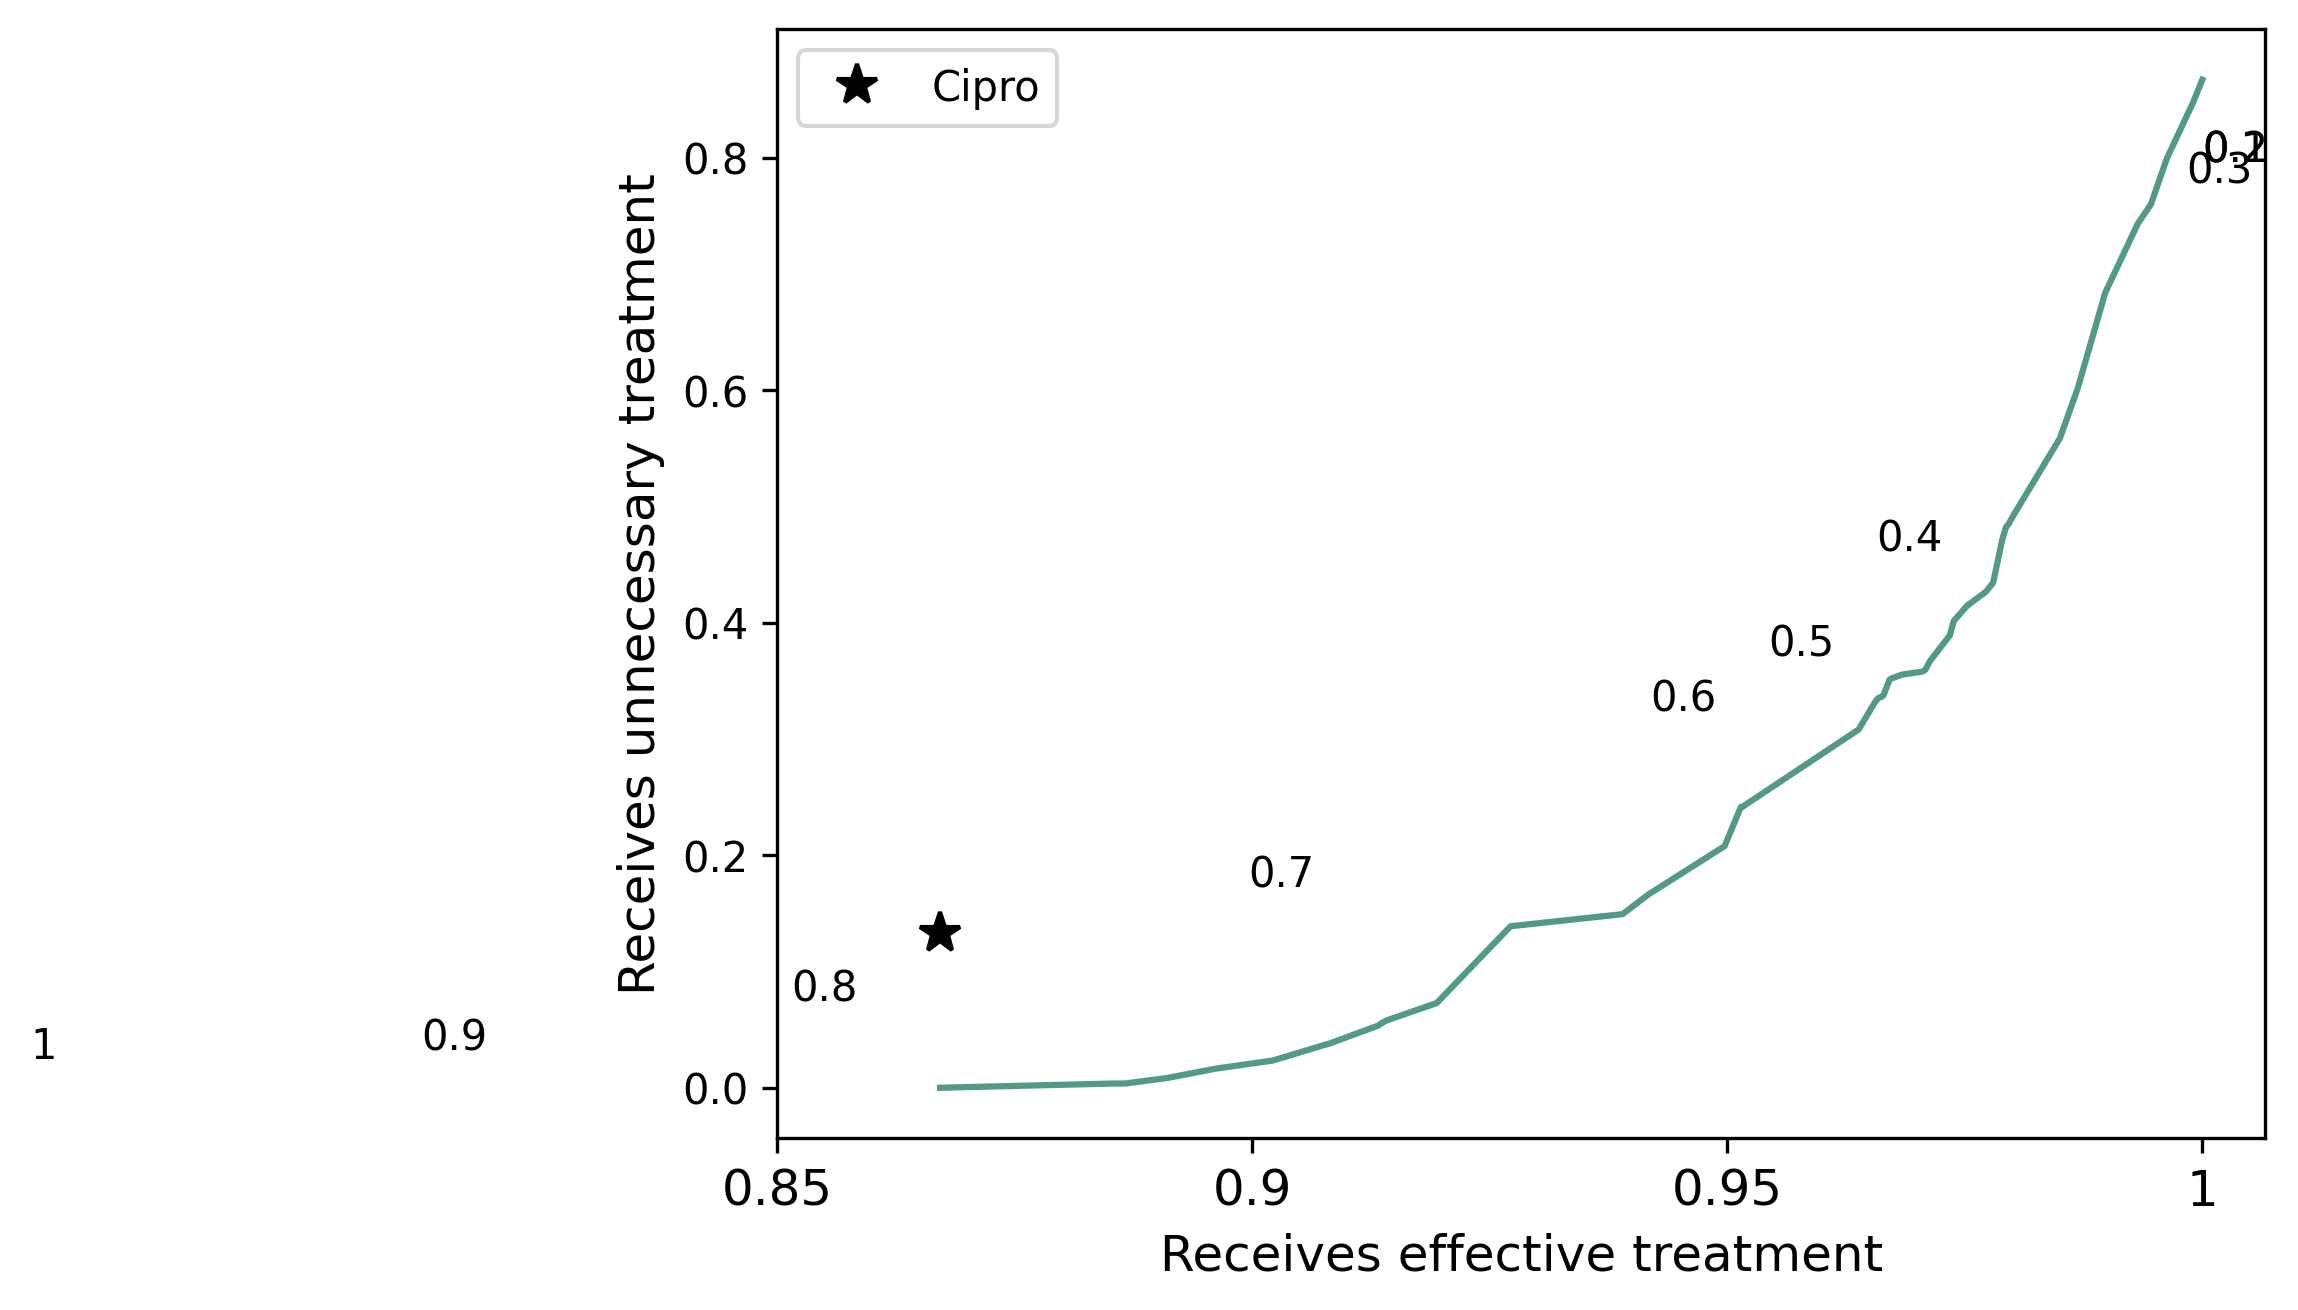

In [22]:
####### What happens if you limit to the previous 5 years
threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([ 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_2011 = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2011)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

get_effective_threshold_prev_5 = []
incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)) #q_p
  incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev_2011) * (1 - specificity_test)) #c_p

## can we compare the "actual" proprtion that would receive the incorrect treatment with the porpor
## that 
plt.plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
    x = x+1

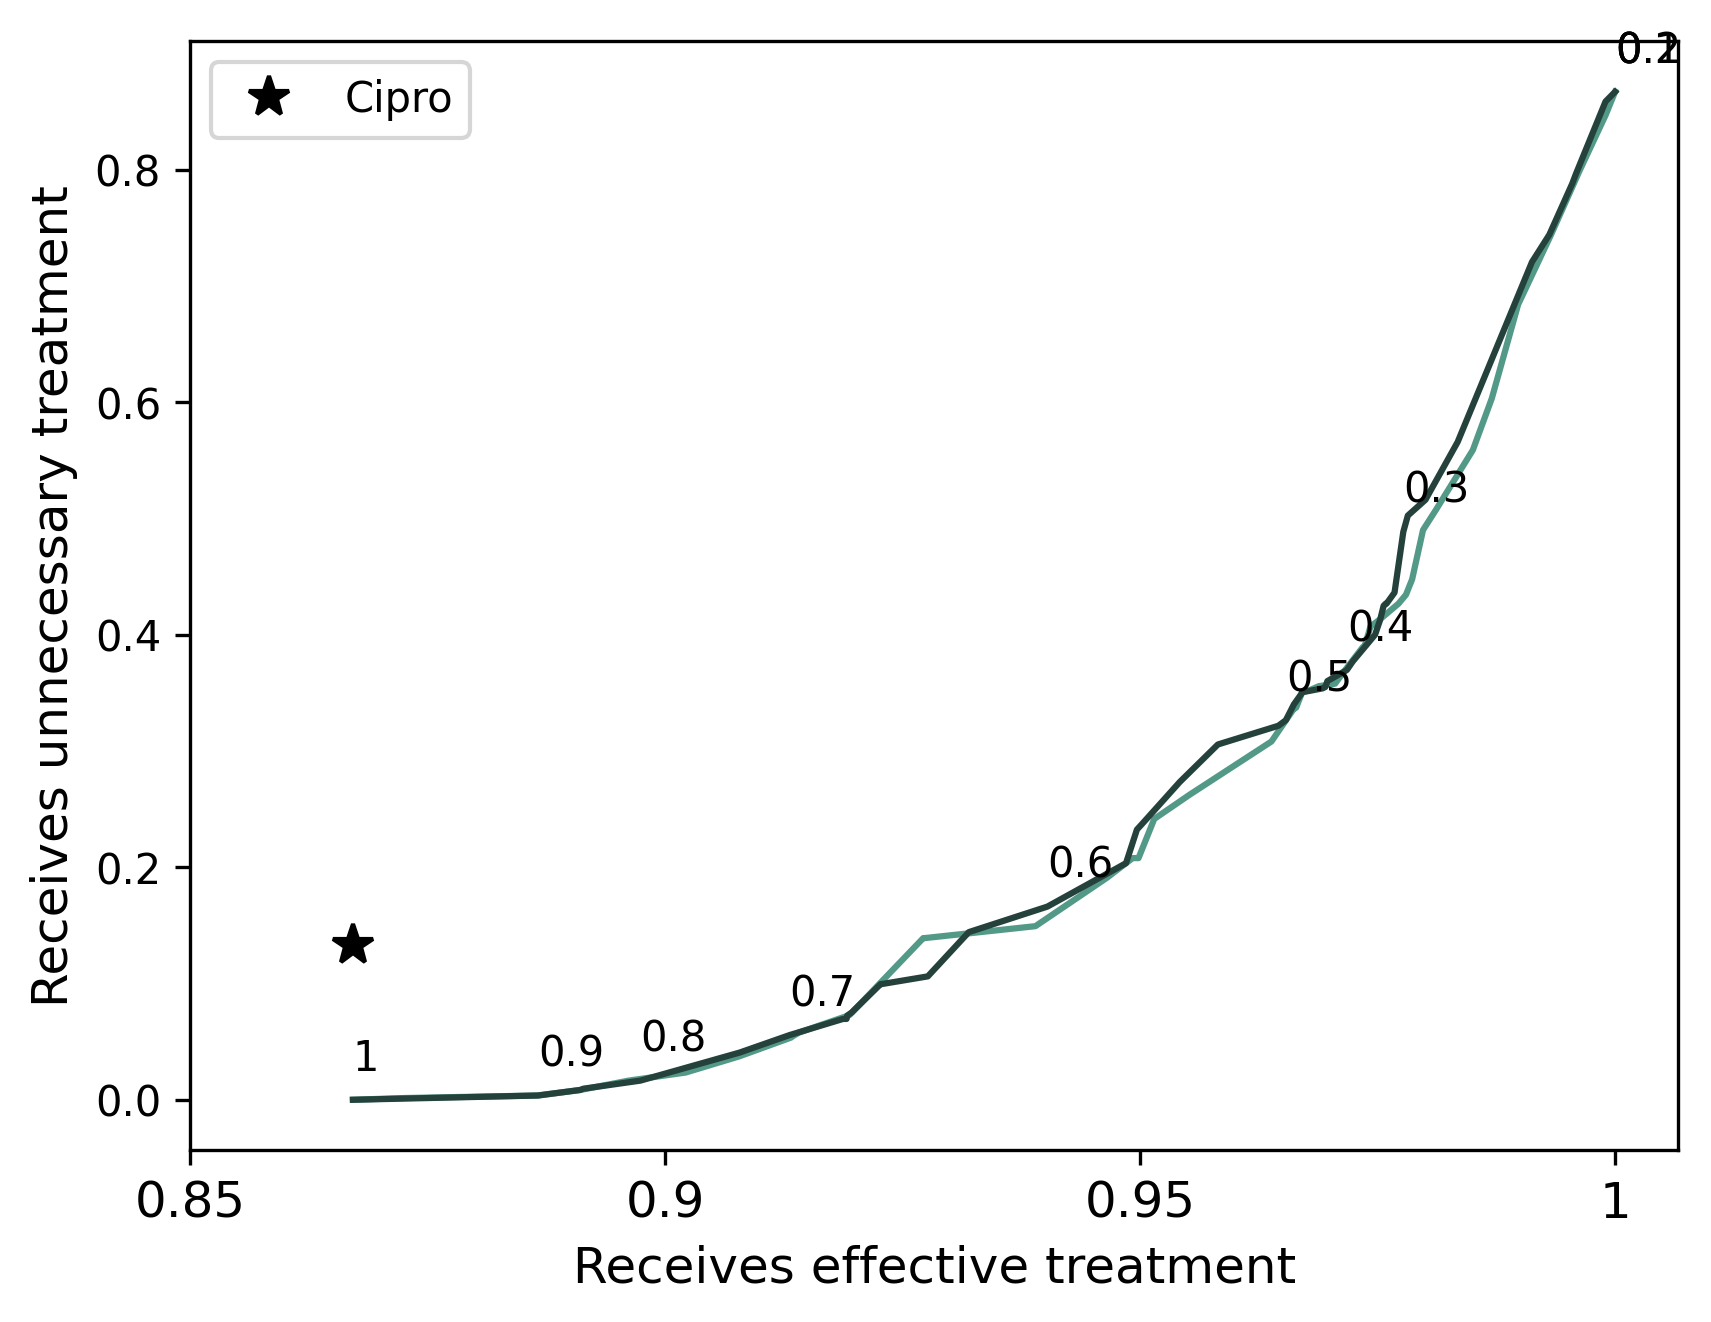

In [60]:
plt.plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")
plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "#24423B")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.85, 0.9, 0.95, 1), ['0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.85)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
    x = x+1

In [14]:
####### Could now calculate the regional benefit ############
###
### first instance, plot where there was a change - only looking at CIPRO, which was no longer recommended by the CDC in 2007

regions = test_data["REGION"].unique()

reistance_by_region  = []

for region in regions:
    CIP_data_region = test_data.loc[test_data['REGION'] == region]
    reistance_by_region.append(1 - CIP_data_region["Susceptible"].sum()/len(CIP_data_region))

        
print(reistance_by_region)




[0.09291338582677167, 0.11996497373029769, 0.0790464240903388, 0.03747534516765283, 0.22867803837953093]


0.09291338582677167
0.11996497373029769
0.0790464240903388
0.03747534516765283
0.22867803837953093


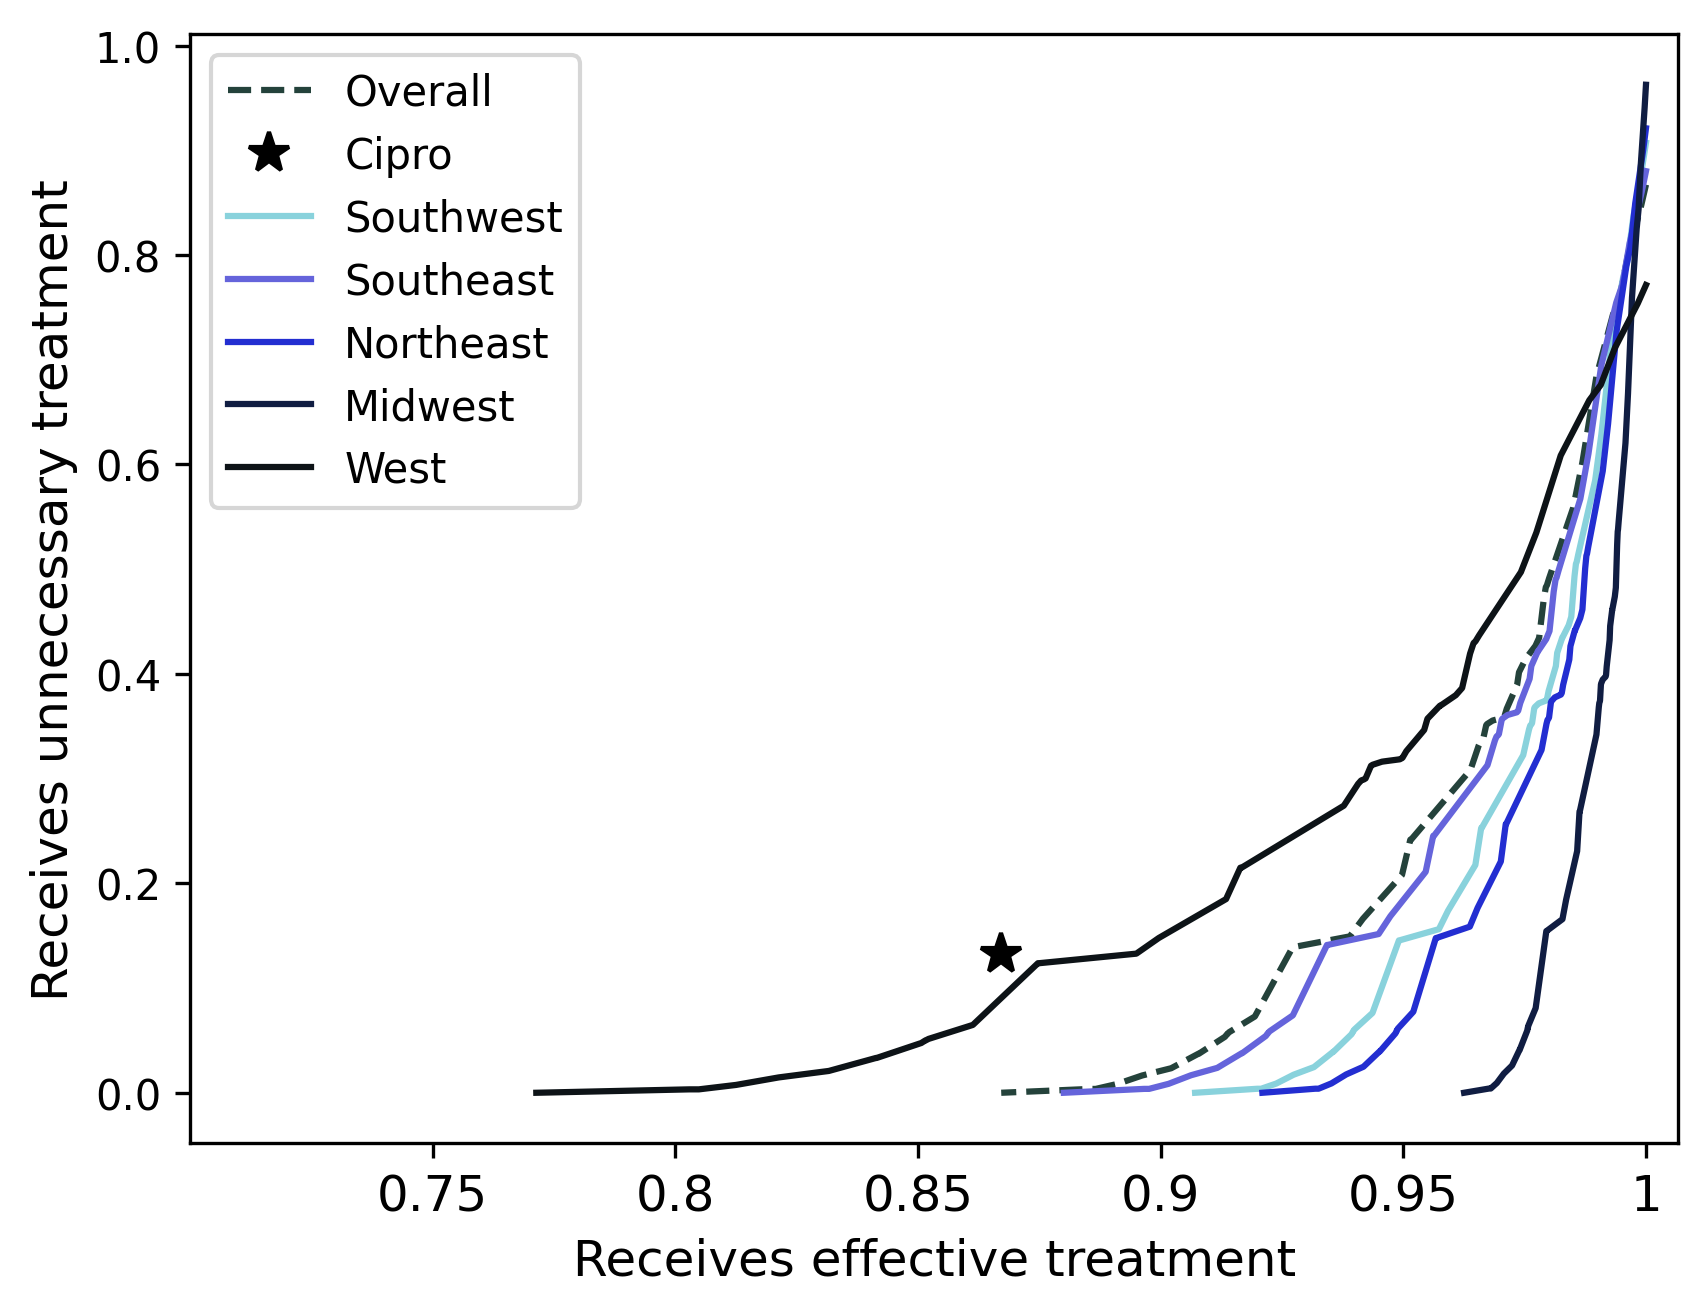

In [29]:
### make main plot, then vary it by year 

plt.plot(get_effective_threshold, incorrectly_get_X_threshold, color = "#24423B", linestyle='dashed', label = "Overall")

plt.xlabel("Receives effective treatment", fontsize=12)
plt.ylabel("Receives unnecessary treatment", fontsize=12)
plt.xticks((0.75, 0.8, 0.85, 0.9, 0.95, 1), ['0.75', '0.8','0.85', '0.9', '0.95', '1'], fontsize=12)
plt.rcParams['figure.dpi'] = 300
plt.xlim(left = 0.7)
#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0

#for index in indices:
#    plt.text(get_effective_threshold[index], incorrectly_get_X_threshold[index] + 0.025, text_for_graph[x])
#    x = x+1

x = 0
colours = ['#89D2DC', '#6564DB', '#232ED1', '#101D42', '#0D1317']

for cipro_R in reistance_by_region:
    print(cipro_R)
    get_effective_threshold_region = []
    incorrectly_get_X_threshold_region  = []
    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
  
        get_effective_threshold_region .append(sensitivity_test * cipro_R + (1 -  cipro_R)) #q_p
        incorrectly_get_X_threshold_region .append((1 - cipro_R) * (1 - specificity_test)) #c_p
    plt.plot(get_effective_threshold_region , incorrectly_get_X_threshold_region , color = colours[x], label = regions[x])
    x += 1

plt.legend()


In [42]:
##Calculate the benefit over the then-current therapy

threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2010 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_2011 = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2011)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

benefit_get_effective_threshold = []
benefit_incorrectly_get_X_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )

  get_effective = sensitivity_test * cipro_R_prev_2011 + (1 -  cipro_R_prev_2011)
  unnecessarily_get_dual_model = (1 - cipro_R_prev_2011) * (1 - specificity_test)

  #under only dual therapy, onlt the current prevalence of resistance "needs" it 
  # 1- (current prevalence) get it unnecessarily
  benefit_over_current_effective = get_effective - 1
  benefit_over_current_unnecessary = unnecessarily_get_dual_model - (1-cipro_R_prev_2011)
  benefit_get_effective_threshold.append(benefit_over_current_effective) #q_p
  benefit_incorrectly_get_X_threshold.append(benefit_over_current_unnecessary) #c_p

0.14488785370753954
0.1328696925329429


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


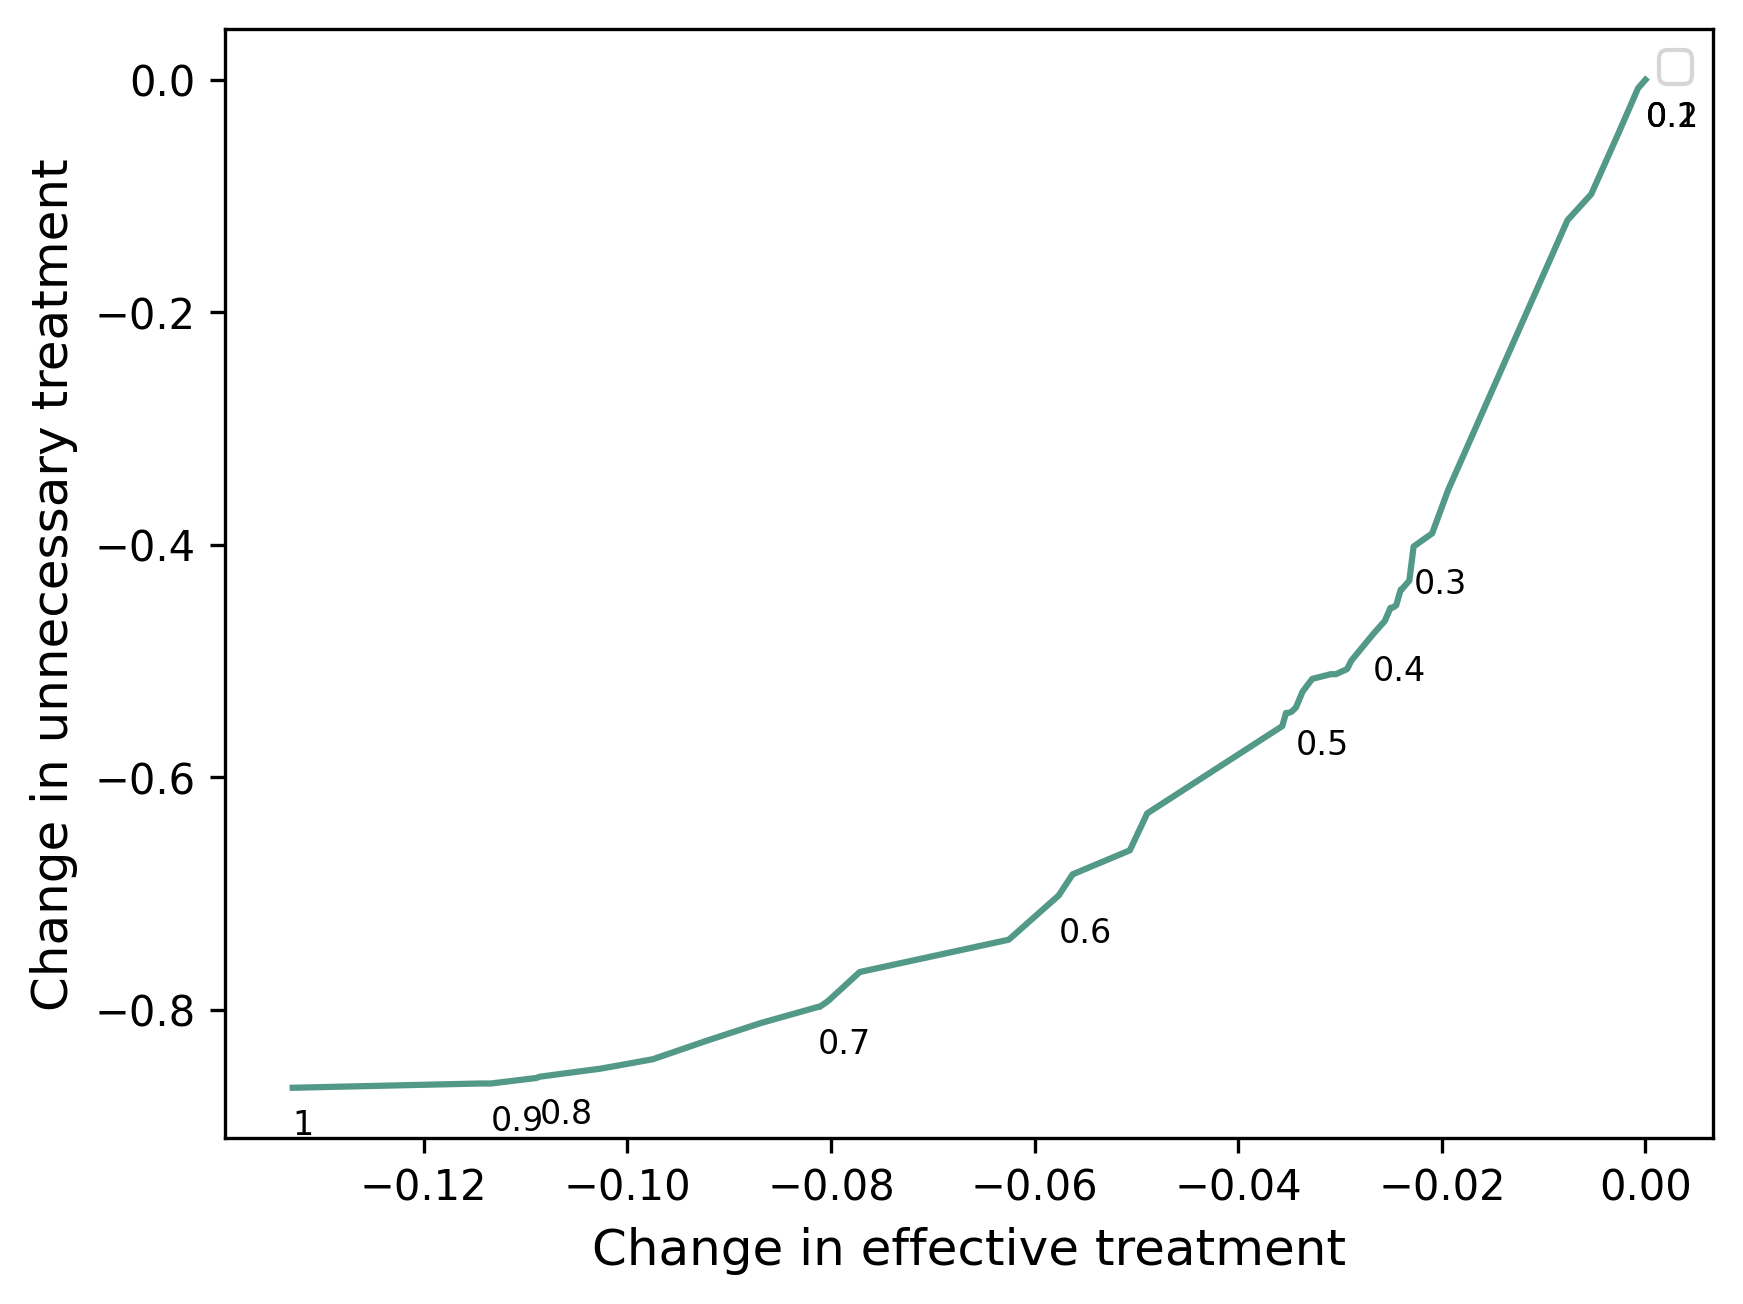

In [45]:
plt.plot(benefit_get_effective_threshold, benefit_incorrectly_get_X_threshold, color = "#539987")

plt.xlabel("Change in effective treatment", fontsize=12)
plt.ylabel("Change in unnecessary treatment", fontsize=12)
plt.rcParams['figure.dpi'] = 300

#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
#plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(benefit_get_effective_threshold[index], benefit_incorrectly_get_X_threshold[index] - 0.04, text_for_graph[x], size = 8)
    x = x+1

0.14488785370753954
0.2235202492211838


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


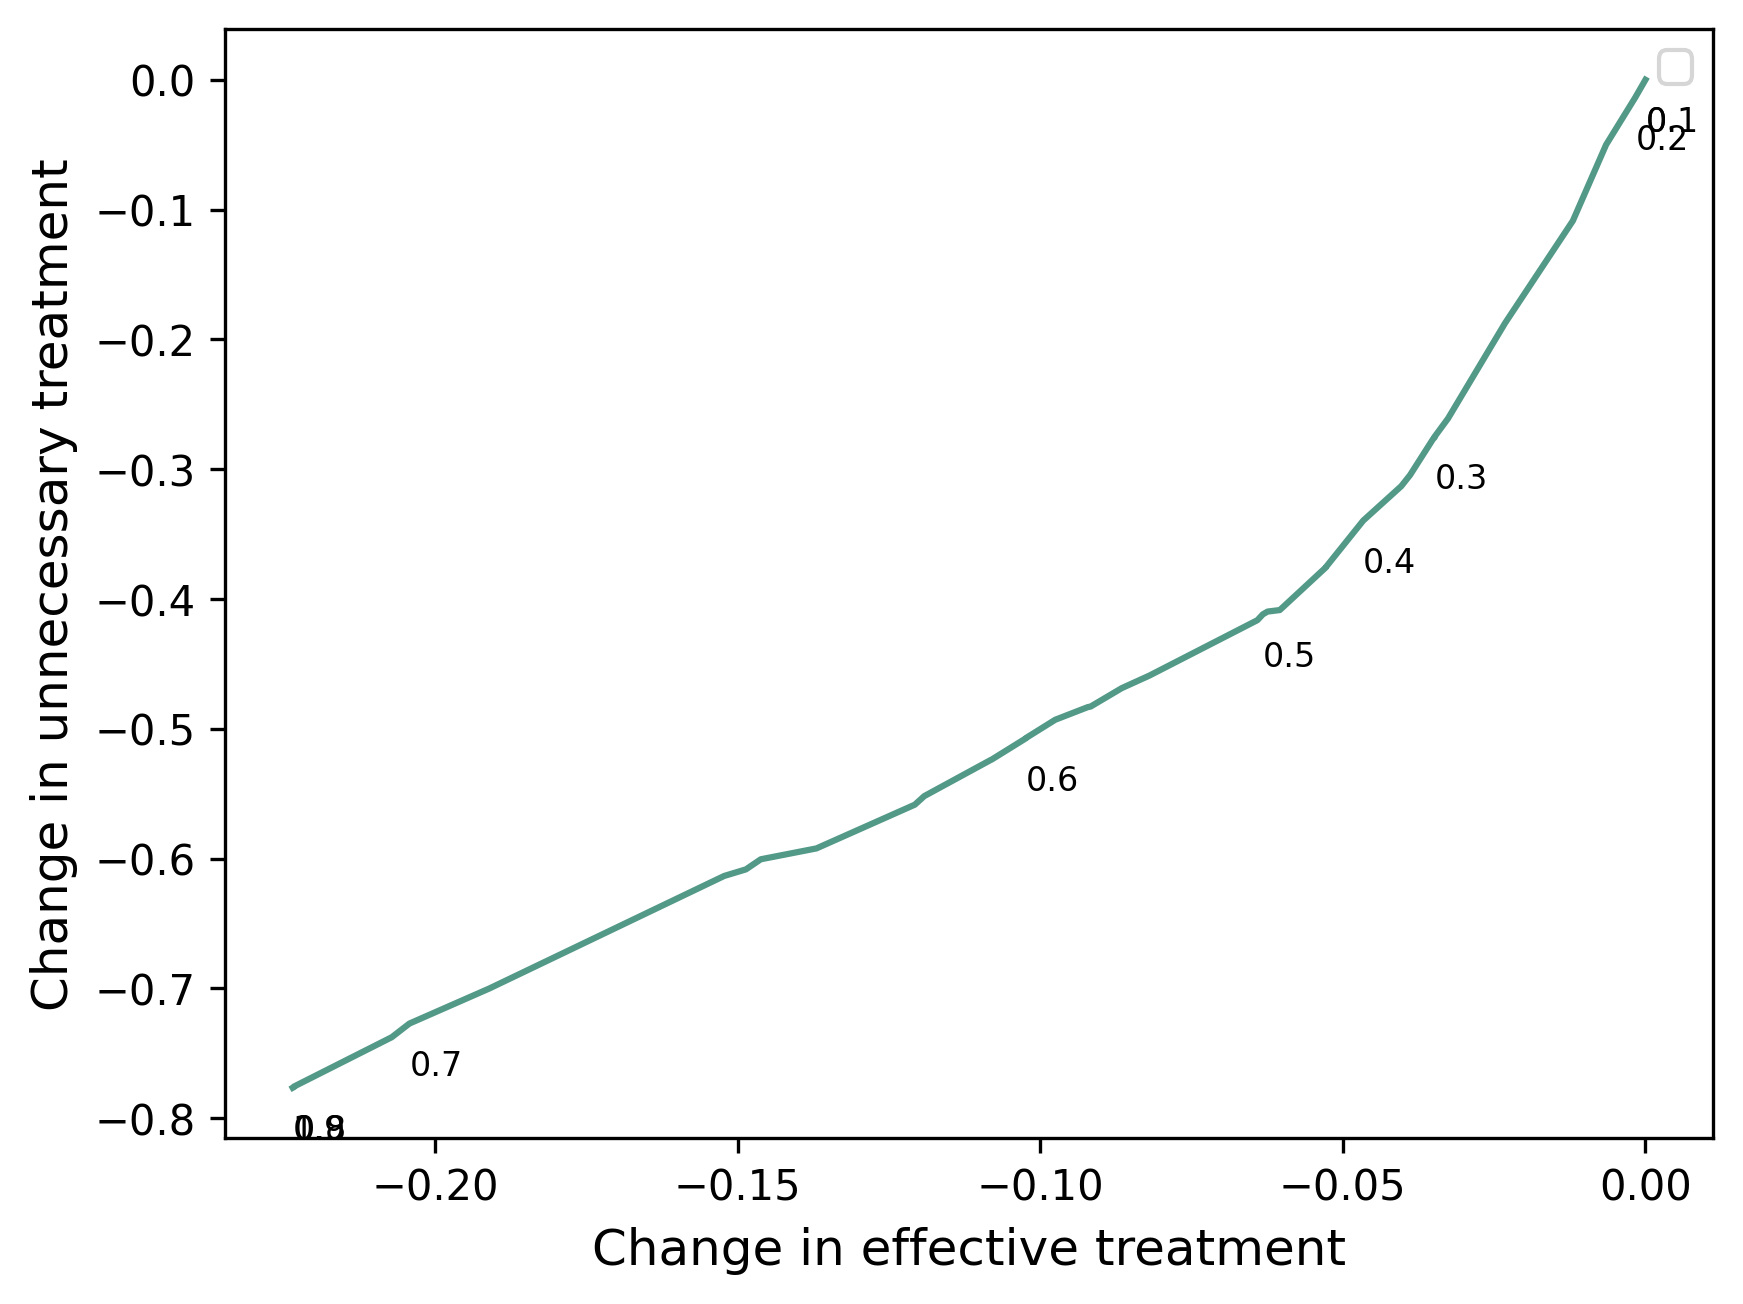

In [62]:
### Repeat for 2015?

##Calculate the benefit over the then-current therapy

threshold_seq = np.linspace(0,1,101)
#for the prevalence, in the TB paper, they used the prevalence to flq in the whole dataset 
#so for us, think that would be 14%
#calculate prevalence of CIP resistance 
prevalence_CIPR = 1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"])
print(1 - CIP_data_no_drop["Susceptible"].sum()/len(CIP_data_no_drop["Susceptible"]))

# need to use the threshold to get the senstivity and specificity of the model 
utility_results = []

### set up model 
model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
#train data: 2000 - 2014 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])]
X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']

oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_train, y_train = oversample.fit_resample(X_train,y_train)


#test data: 2011 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2015])]
X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
cipro_R_prev_2015 = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
X_test, y_test = oversample.fit_resample(X_test,y_test)

print(cipro_R_prev_2015)

model_fit_train = model_nn.fit(X_train, y_train)
y_predict_test = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)
ROC_AUC_2015 = metrics.roc_auc_score(y_test, y_predict_test)

benefit_get_effective_threshold_2015 = []
benefit_incorrectly_get_X_threshold_2015 = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:

  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )

  get_effective = sensitivity_test * cipro_R_prev_2015 + (1 -  cipro_R_prev_2015)
  unnecessarily_get_dual_model = (1 - cipro_R_prev_2015) * (1 - specificity_test)

  #under only dual therapy, onlt the current prevalence of resistance "needs" it 
  # 1- (current prevalence) get it unnecessarily
  benefit_over_current_effective = get_effective - 1
  benefit_over_current_unnecessary = unnecessarily_get_dual_model - (1-cipro_R_prev_2015)
  benefit_get_effective_threshold_2015.append(benefit_over_current_effective) #q_p
  benefit_incorrectly_get_X_threshold_2015.append(benefit_over_current_unnecessary) #c_p



plt.plot(benefit_get_effective_threshold_2015, benefit_incorrectly_get_X_threshold_2015, color = "#539987")

plt.xlabel("Change in effective treatment", fontsize=12)
plt.ylabel("Change in unnecessary treatment", fontsize=12)
plt.rcParams['figure.dpi'] = 300

#plt.plot(cipro_R_prev_2011, 1 - cipro_R_prev_2011, marker='.', ls='none', ms=10, color = "black", label = "Dual")
#plt.plot((1-cipro_R_prev_2011), cipro_R_prev_2011, marker='*', ls='none', ms=10, color = "black", label = "Cipro")
#plt.plot([0], get_effective_threshold[0], marker='*', ls='none', ms=10, color = "black", label = "Dual")
plt.legend()
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
x = 0
for index in indices:
    plt.text(benefit_get_effective_threshold_2015[index], benefit_incorrectly_get_X_threshold_2015[index] - 0.04, text_for_graph[x], size = 8)
    x = x+1

In [52]:
print(ROC_AUC_2015)

0.6033099297893681


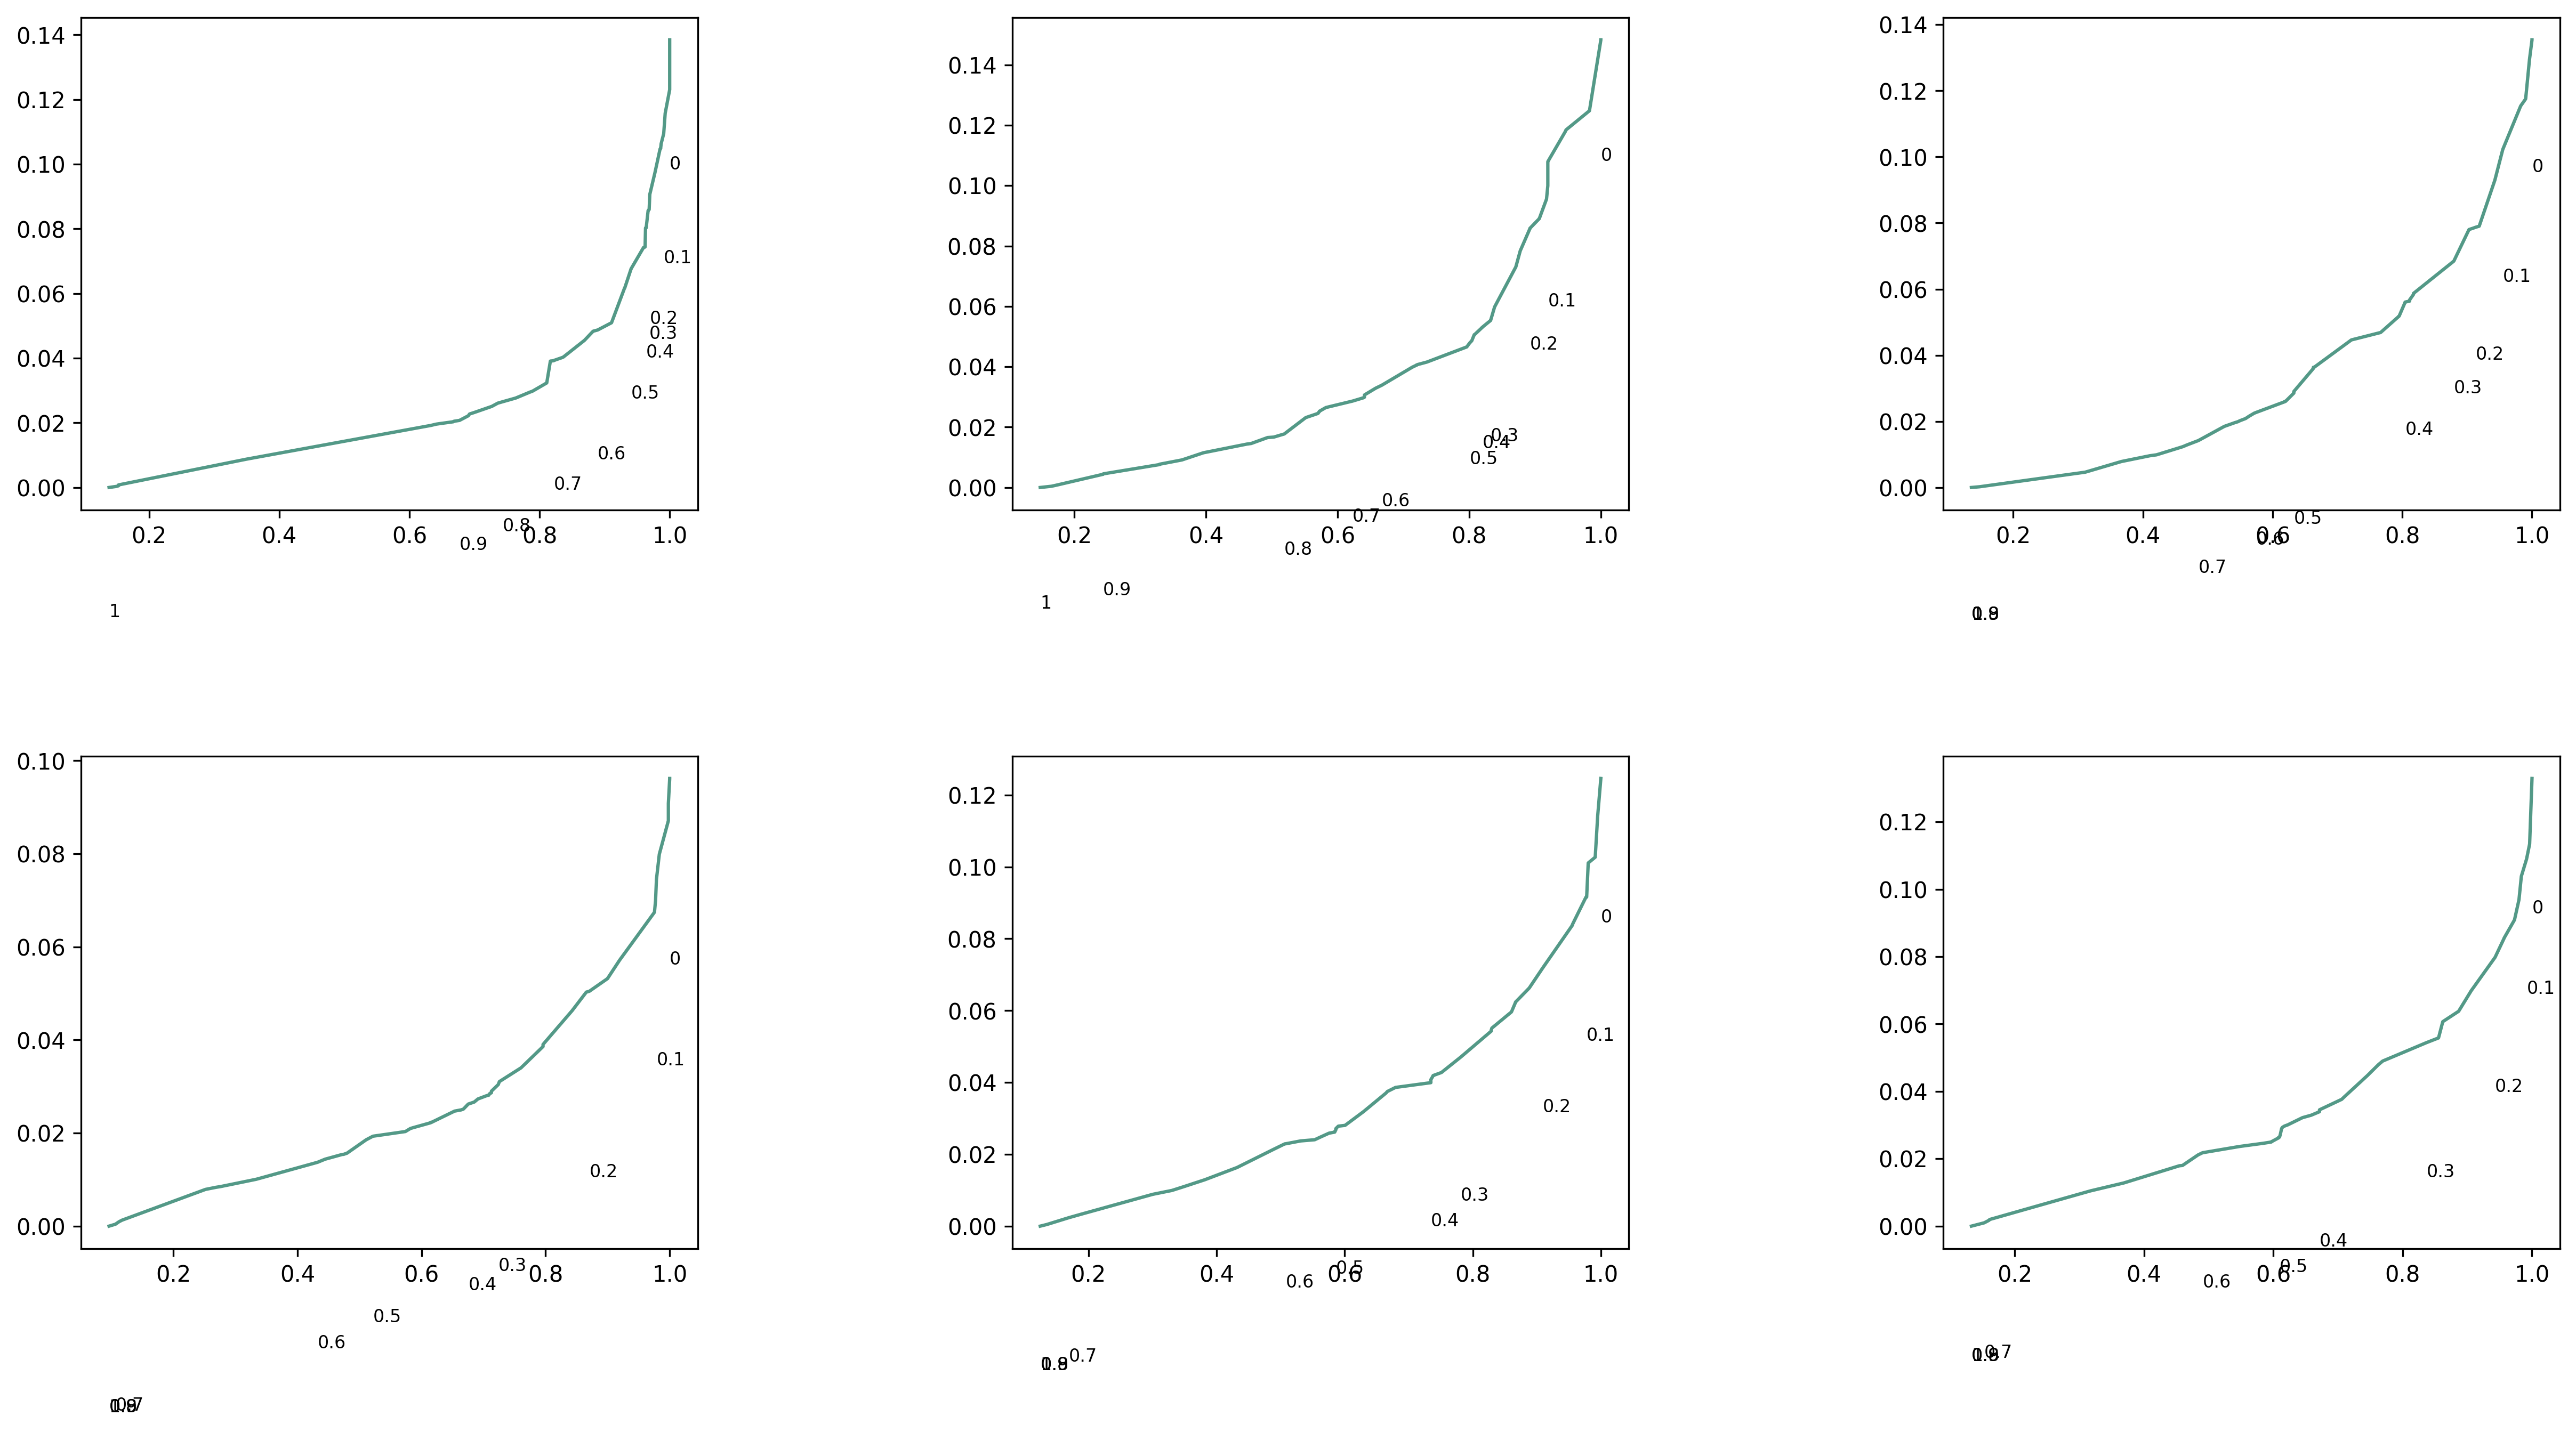

In [82]:
### now do a loop 

years = [2006, 2007, 2008, 2009, 2010, 2011]
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)
text_for_graph = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']
indices = [0,10,20,30,40,50,60,70,80,90,100]
fig, axs = plt.subplots(2,3, figsize=(20, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.51)
axs = axs.ravel()
i = 0
for year in years: 
    model_nn = MLPClassifier(solver = 'lbfgs', activation = 'tanh', max_iter = 3000 ,hidden_layer_sizes= 13, alpha = 1.291549665014884, random_state=10, learning_rate = 'constant' )
    #train
    years_train = np.array(range(year - 5, year))
    train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin(years_train)]
    X_train = train_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
    y_train = 1 - train_data['Susceptible']
    X_train, y_train = oversample.fit_resample(X_train,y_train)
    #test
    test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([year])]
    X_test = test_data[['MSM','MSMW', 'MSW','Northeast', 'Southeast', 'West', 'Midwest','PREV_REGION','PREV_CLINIC', 'DELTA_REGION']]
    y_test = 1 - test_data['Susceptible']
    cipro_R_prev = y_test.sum()/len(y_test) #get prevalence in 2011 before radndom oversampling - don't do 1-y_test because now y_test is resistance
    X_test, y_test = oversample.fit_resample(X_test,y_test)
    model_fit_train = model_nn.fit(X_train, y_train)
    y_predict_test = model_fit_train.predict(X_test)
    y_predict_proba = model_fit_train.predict_proba(X_test)

    get_effective_threshold_prev_5 = []
    incorrectly_get_X_threshold_prev_5 = [] #no bootstrapping, no 95% CI 

    for threshold in threshold_seq:

        y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

        tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

        sensitivity_test  = tp_test  / (tp_test   + fn_test )
        specificity_test   = tn_test / (tn_test + fp_test )
    
        get_effective_threshold_prev_5.append(sensitivity_test * cipro_R_prev + (1 -  cipro_R_prev)) #q_p
        incorrectly_get_X_threshold_prev_5.append((1 - cipro_R_prev) * (1 - specificity_test)) #c_p
    x = 0
    axs[i].plot(get_effective_threshold_prev_5, incorrectly_get_X_threshold_prev_5, color = "#539987")
    for index in indices:
        axs[i].text(get_effective_threshold_prev_5[index], incorrectly_get_X_threshold_prev_5[index] - 0.04, text_for_graph[x], size = 8)
        x += 1
    i += 1   
